The goal of this notebook is to see what happens when we preprocess pulses in the frequency domain, but then later convert back to time domain.

In [109]:
import os
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal.windows import tukey
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [110]:
# Loading ex-vivo data
path_to_data = "Data\\Ex-Vivo\\"
files = os.listdir(path_to_data)

# Removing readme
files.remove("READ_ME.txt")

data = []

for file in files:
    with open(path_to_data + file, 'rb') as f:
        data.append(pickle.load(f))

# sorting data based on date

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])

x = data[4]['scan'][0]['forward_scan']['time']
y = data[4]['scan'][0]['forward_scan']['signal']

# Fixing labeling errors

data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5


# Fixing issue with sample ids due to multiple days

for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix


# Removing air and NC as these are irrelevant for our purpose
data = [d for d in data if not d['samplematrix_fixed'] == 'air']

ids_to_remove = []

for d in data:
    values = d['samplematrix_fixed'].split()
    if values[2] == 'NC':
        ids_to_remove.append(values[1])

data = [d for d in data if not d['samplematrix_fixed'].split()[1] in ids_to_remove]

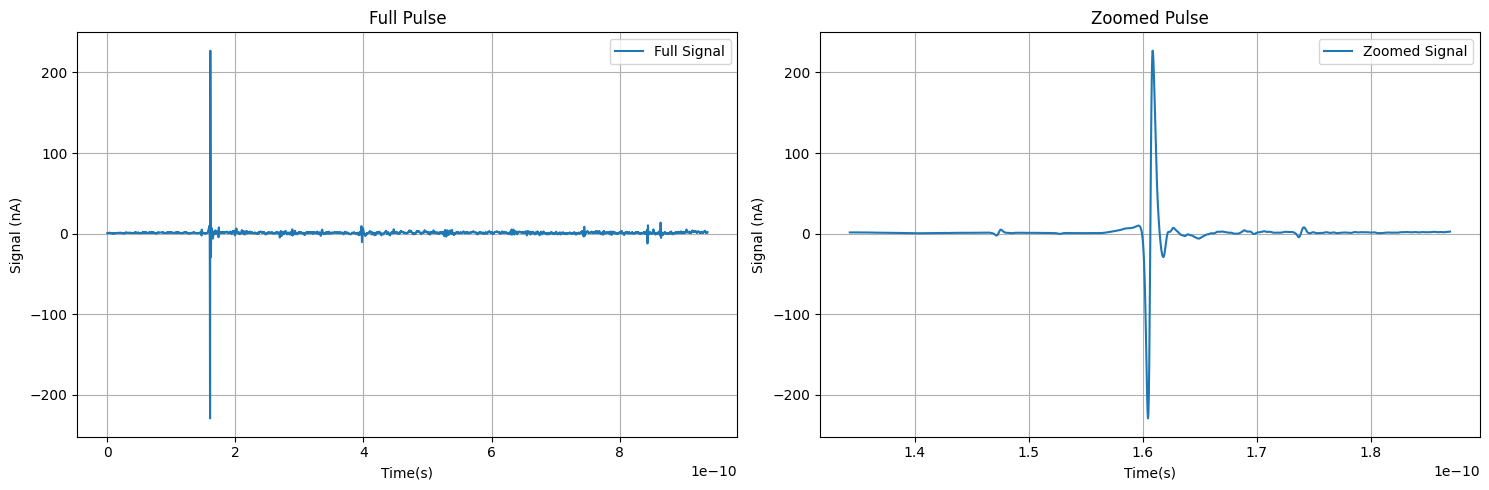

In [111]:
min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [112]:
# just taking first forward scan in each file
for d in data:
    d['avg_signal'] = d['scan'][0]['forward_scan']['signal']
    d['avg_time'] = d['scan'][0]['forward_scan']['time']

    d['avg_ref_signal'] = d['ref'][0]['forward_scan']['signal']
    d['avg_ref_time'] = d['ref'][0]['forward_scan']['time']

In [113]:
# Applying Tukey window to all signals

window_size = 325
alpha = 0.80

for d in data:

    # Applying Tukey window to avg signal
    y = d['avg_signal']
    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index+max_index)/2)
    window_start = middle_index - window_size
    window_end = middle_index + window_size
    window = tukey(window_end-window_start, alpha = alpha)
    windowed_signal = y[window_start: window_end] * window
    y = np.zeros(len(y), dtype=float)
    y[window_start: window_end] = windowed_signal

    d['avg_tukey'] = y
    
    # Applying Tukey window to avg ref signal
    y = d['avg_ref_signal']
    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index+max_index)/2)
    window_start = middle_index - window_size
    window_end = middle_index + window_size
    window = tukey(window_end-window_start, alpha = alpha)
    windowed_signal = y[window_start: window_end] * window
    y = np.zeros(len(y), dtype=float)
    y[window_start: window_end] = windowed_signal

    d['avg_ref_tukey'] = y

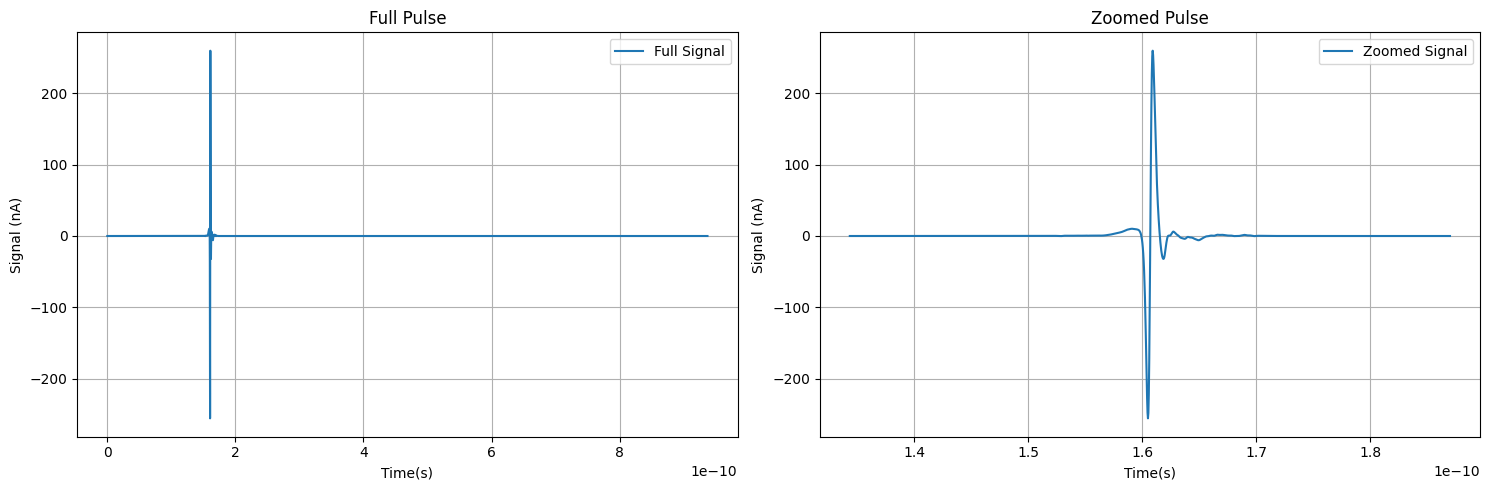

In [114]:
# Plotting effect of tukey window
x = data[4]['avg_time']
y = data[4]['avg_tukey']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Full Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Full Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Zoomed Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulse")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [115]:
# Applying FFT to all signals

for d in data:

    # Applying FFT to avg signal
    x = d['avg_time']
    y = d['avg_tukey']

    fft_result = np.fft.rfft(y)

    amplitudes = np.abs(fft_result)

    amplitudes = amplitudes / len(y)

    # FFT output is symmetric, so taking just the first half
    frequencies = np.fft.rfftfreq(len(y), x[1] - x[0])
    frequencies = frequencies * (10**(-12))
    d['avg_amplitudes'] = amplitudes
    d['avg_frequencies'] = frequencies

    # Applying FFT to avg ref signal
    x = d['avg_ref_time']
    y = d['avg_ref_tukey']

    fft_result = np.fft.rfft(y)

    amplitudes = np.abs(fft_result)  

    amplitudes = amplitudes / len(y)

    frequencies = np.fft.rfftfreq(len(y), x[1] - x[0])
    frequencies = frequencies * (10**(-12))
    d['avg_ref_amplitudes'] = amplitudes
    d['avg_ref_frequencies'] = frequencies

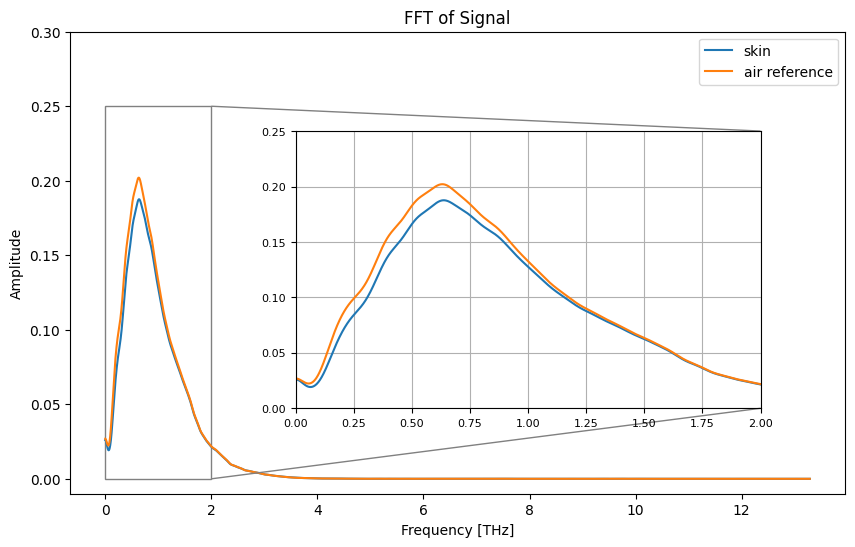

In [116]:
# Plotting FFT

xf_scan = data[1]['avg_frequencies']
yf_scan = data[1]['avg_amplitudes']

xf_ref = data[1]['avg_ref_frequencies']
yf_ref = data[1]['avg_ref_amplitudes']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(xf_scan, yf_scan, label='skin')
ax.plot(xf_ref, yf_ref, label='air reference')
ax.set_ylim(-0.01, 0.3)

ax.set_xlabel('Frequency [THz]')
ax.set_ylabel('Amplitude')
ax.set_title('FFT of Signal')

inset_ax = inset_axes(ax, width="150%", height="150%", loc='upper right',
                      bbox_to_anchor=(0.5, 0.4, 0.4, 0.4),
                      bbox_transform=ax.transAxes)

inset_ax.plot(xf_scan, yf_scan, label='Signal')
inset_ax.plot(xf_ref, yf_ref, label='Signal')

# defining the zoom
inset_ax.set_xlim(0, 2)  
inset_ax.set_ylim(0, .25)  

inset_ax.grid(True)

inset_ax.tick_params(axis='both', which='major', labelsize=8)

mark_inset(ax, inset_ax, loc1=1, loc2=4, fc="none", ec="0.5")

ax.legend()

plt.show()

In [117]:
# Normalizing the amplitudes using it's air reference
for d in data:
    amplitudes = d['avg_amplitudes']
    ref_amplitudes = d['avg_ref_amplitudes']
    normalized_amplitudes = amplitudes / ref_amplitudes
    d['avg_amplitudes_norm'] = normalized_amplitudes

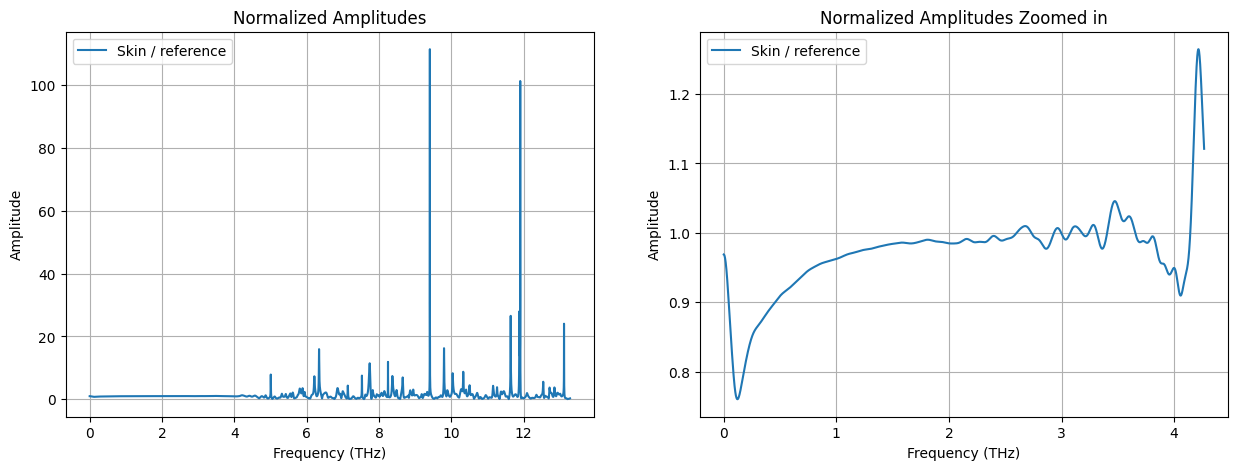

In [118]:
# Plotting Normalized Amplitudes

xf = data[1]['avg_frequencies']
yf = data[1]['avg_amplitudes_norm']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf, yf, label='Skin / reference')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf[0:4000], yf[0:4000], label='Skin / reference')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

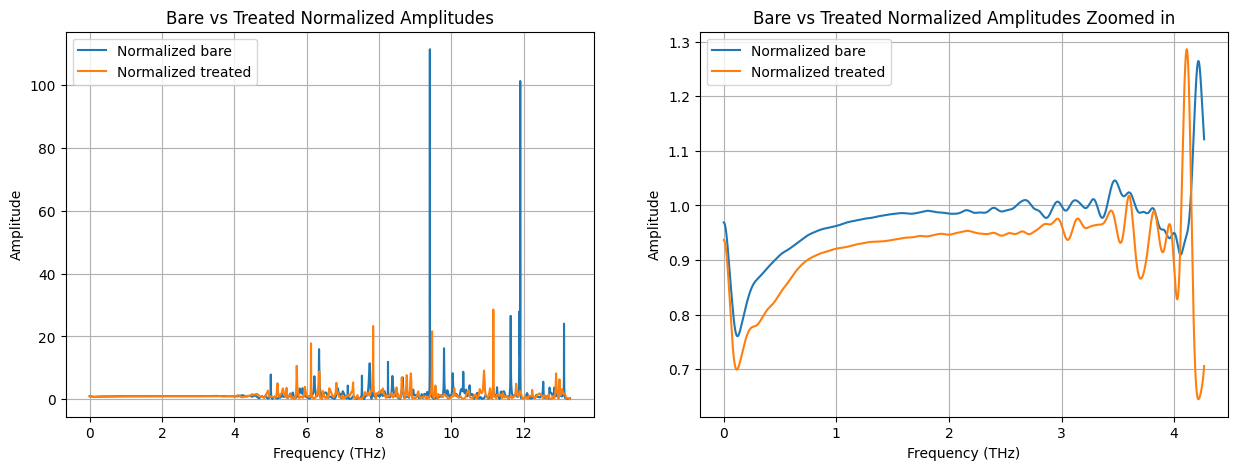

In [119]:
# Plotting the normalized bare pulse vs its corresponding normalized treated pulse
xf_bare = data[1]['avg_frequencies']
yf_bare = data[1]['avg_amplitudes_norm']

xf_treated = data[7]['avg_frequencies']
yf_treated = data[7]['avg_amplitudes_norm']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_bare, yf_bare, label='Normalized bare')
plt.plot(xf_treated, yf_treated, label='Normalized treated')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_bare[0:4000], yf_bare[0:4000], label='Normalized bare')
plt.plot(xf_treated[0:4000], yf_treated[0:4000], label='Normalized treated')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [120]:
# Creating sample ID as separate field in data dict
for d in data:
    d['sample_id'] = d['samplematrix_fixed'].split()[1]

In [121]:
# Normalizing treated pulse using its corresponding bare pulse  (Is this the correct way?)
bare_data = [d for d in data if 'bare' in d['samplematrix_fixed']]
treated_data = [d for d in data if not 'bare' in d['samplematrix_fixed']]

for t in treated_data:
    b = [b for b in bare_data if b['sample_id'] == t['sample_id']][0]
    t['avg_amplitudes_norm_treated'] = t['avg_amplitudes_norm'] / b['avg_amplitudes_norm']

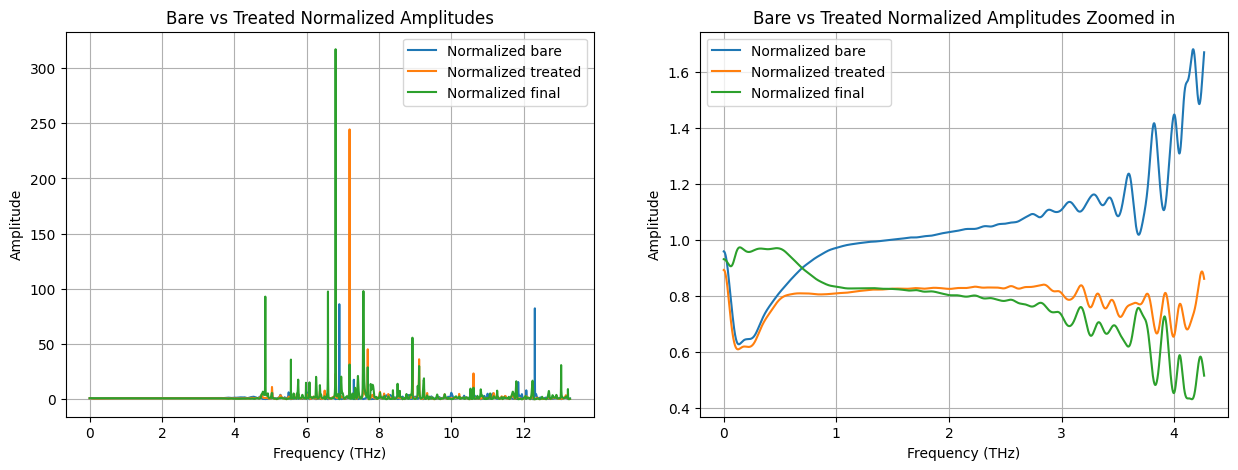

In [122]:
treated_datapoint = treated_data[0]
corresponding_bare = [b for b in bare_data if b['sample_id'] == treated_datapoint['sample_id']][0]

xf_bare = corresponding_bare['avg_frequencies']
yf_bare = corresponding_bare['avg_amplitudes_norm']

xf_treated = treated_datapoint['avg_frequencies']
yf_treated = treated_datapoint['avg_amplitudes_norm']

xf_final = treated_datapoint['avg_frequencies']
yf_final = treated_datapoint['avg_amplitudes_norm_treated']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(xf_bare, yf_bare, label='Normalized bare')
plt.plot(xf_treated, yf_treated, label='Normalized treated')
plt.plot(xf_final, yf_final, label='Normalized final')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(xf_bare[0:4000], yf_bare[0:4000], label='Normalized bare')
plt.plot(xf_treated[0:4000], yf_treated[0:4000], label='Normalized treated')
plt.plot(xf_final[0:4000], yf_final[0:4000], label='Normalized final')
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("Bare vs Treated Normalized Amplitudes Zoomed in")
plt.legend()
plt.grid(True)

plt.show()

In [123]:
# converting the final pulse to time domain
for t in treated_data:
    xf = t['avg_frequencies']
    yf = t['avg_amplitudes_norm_treated']

    fft_result = np.fft.irfft(yf)

    t['signal_inversed'] = fft_result

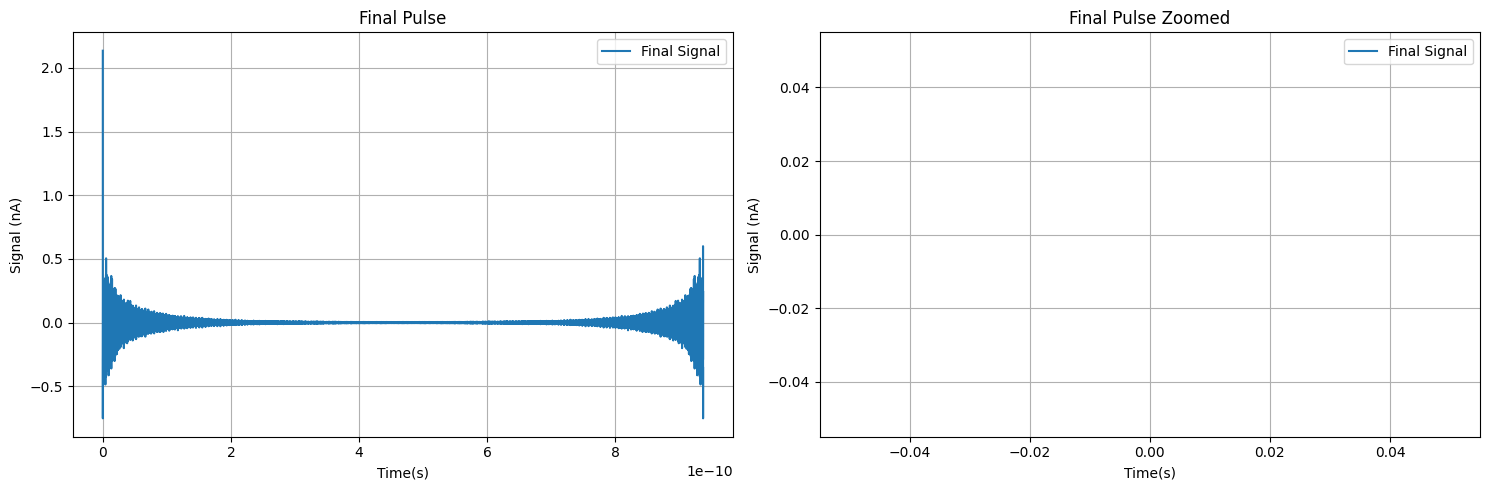

In [124]:
# plotting the final pulse in time domain
treated_datapoint = treated_data[0]
x = treated_datapoint['avg_time']
y = treated_datapoint['signal_inversed']

min_index = np.argmin(y)
max_index = np.argmax(y)
middle_index = math.floor((min_index + max_index) / 2)
zoom_start = middle_index - 700
zoom_end = middle_index + 700

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(x, y, label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Final Signal')
plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Final Pulse Zoomed")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()